In [38]:
%load_ext autoreload
%autoreload 2

# Multi-Task BO NIPS Paper

![](figures/baumgartner_mechanisms.png)

In [10]:
from summit.strategies import STBO, MTBO, Transform, LHS, Chimera
from summit.benchmarks import (
    MIT_case1,
    MIT_case2,MIT_case3,
    MIT_case4,
    MIT_case5,
    BaumgartnerCrossCouplingEmulator
)
from summit.utils.dataset import DataSet
from summit.domain import *
import summit
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from IPython.display import clear_output

In [39]:
def run_stbo(exp, max_iterations=10, categorical_method="one-hot"):
    exp.reset()
    strategy = STBO(exp.domain, 
                    categorical_method=categorical_method)
    r = summit.Runner(strategy=strategy, 
                      experiment=exp, 
                      max_iterations=max_iterations)
    r.run()
    return r

def run_mtbo(exp, pt_data, max_iterations=10):
    strategy = MTBO(exp.domain, 
                    pretraining_data=pt_data,
                    categorical_method="one-hot", 
                    task=1)
    r = summit.Runner(strategy=strategy,
                      experiment=exp, 
                      max_iterations=max_iterations)
    r.run()
    return r

def make_average_plot(results: List[summit.Runner], ax, label=None, color=None):
    yields = [r.experiment.data['y'] for r in results]
    yields = np.array(yields)
    mean_yield = np.mean(yields, axis=0)
    std_yield = np.std(yields, axis=0)
    x = np.arange(0, len(mean_yield), 1).astype(int)
    ax.plot(x, mean_yield, label=label, linewidth=2)
    ax.fill_between(x, mean_yield-std_yield, mean_yield+std_yield, alpha=0.1)

def make_comparison_plot(*args):
    fig, ax = plt.subplots(1)
    for arg in args:
        make_average_plot(arg['results'], ax, label=arg["label"], color=arg.get("color"))
    fontdict = fontdict={"size":12}
    ax.legend(loc = "lower right", prop=fontdict)
    ax.set_xlim(0,20)
    ax.set_xticks(np.arange(0, 20, 2).astype(int))
    ax.set_ylabel('Yield', fontdict=fontdict)
    ax.set_xlabel('Reactions', fontdict=fontdict)
    ax.tick_params(direction='in')
    return fig, ax

In [12]:
N_REPEATS = 10
MAX_ITERATIONS = 20

## Comparing Similar Kinetic Models

We will use MIT case 1 as the auxiliary task for pretraining.

In [6]:
exp_pt = MIT_case1(noise_level=1)
exp_pt.domain

Name,Type,Description,Values
conc_cat,"continuous, input",catalyst concentration,"[0.000835,0.004175]"
t,"continuous, input",reaction time,"[60,600]"
cat_index,"categorical, input",Choice of catalyst,8 levels
temperature,"continuous, input",Reactor temperature in degress celsius,"[30,110]"
y,"continuous, maximize objective",yield (%),"[0,100]"


We first generate different amounts of data using latin hypercube sampling.

Now, we can run single-task and multi-task Bayesian optimization.

In [8]:
def generate_mit_case_1_data(n_points):
    exp_pt = MIT_case1(noise_level=1)
    rs = np.random.RandomState(100)
    lhs = LHS(exp_pt.domain, random_state=rs)
    conditions = lhs.suggest_experiments(n_points)
    exp_pt.run_experiments(conditions)
    pt_data = exp_pt.data
    pt_data['task', 'METADATA'] = 0
    return pt_data

n_aux = [5, 10, 50]
aux_datasets = [generate_mit_case_1_data(n) for n in n_aux]

In [ ]:
#Single-Task Bayesian Optimization
for i in range(N_REPEATS):
    print(f"Repeat {i}")
    exp = MIT_case2(noise_level=1)
    result = run_stbo(exp, max_iterations=MAX_ITERATIONS)
    result.save(f"data/kinetics_similar/stbo_case1-2_noise_repeat_{i}.json")
    clear_output(wait=True)

In [23]:
#Multi-Task Bayesian Optimization
for n, dataset in zip(n_aux, aux_datasets):
    for i in range(N_REPEATS):
        print(f"Repeat {i}")
        exp = MIT_case2(noise_level=1)
        result = run_mtbo(exp, dataset, max_iterations=MAX_ITERATIONS)
        result.save(f"data/kinetics_similar/mtbo_case1-2_noise_{n}-pre-train_repeat_{i}.json")
        clear_output(wait=True)

Repeat 9


Finally, we can make a plot for the paper.

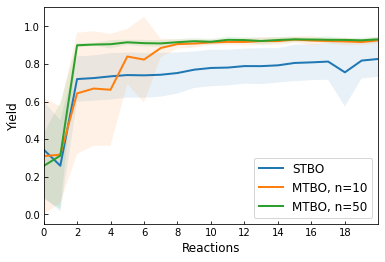

In [40]:
stbo_results = [summit.Runner.load(f"data/kinetics_similar/stbo_case1-2_noise_repeat_{i}.json") for i in range(10)]
mtbo_results_lists = [[summit.Runner.load(f"data/kinetics_similar/mtbo_case1-2_noise_{n}-pre-train_repeat_{i}.json") 
                      for i in range(10)]
                      for n in n_aux]
fig, ax = make_comparison_plot(
    dict(results=stbo_results, label="STBO"),
#     dict(results=mtbo_results_lists[0],label="MTBO, n=5"),
    dict(results=mtbo_results_lists[1],label="MTBO, n=10"),
    dict(results=mtbo_results_lists[2],label="MTBO, n=50")
)
fig.savefig("figures/stbo_mtbo_kinetics_case1-2_noise_comparison.png", bbox_inches='tight', dpi=300)

## Comparing Different Mechanisms

This adds an extra wrinkle because there is a competing reaction which consumes B (see Case 3 from figure above).

In [32]:
#Single-Task Bayesian Optimization
for i in range(N_REPEATS):
    print(f"Repeat {i}")
    exp = MIT_case3(noise_level=1)
    result = run_stbo(exp, max_iterations=MAX_ITERATIONS)
    result.save(f"data/kinetics_different/stbo_case1-3_noise_repeat_{i}.json")
    clear_output(wait=True)

Repeat 9


In [13]:
#Multi-Task Bayesian Optimization
j = 2
pt_data = aux_datasets[j]
n=n_aux[j]
for i in range(N_REPEATS):
    print(f"Repeat {i}")
    exp = MIT_case3(noise_level=1)
    result = run_mtbo(exp, pt_data, max_iterations=MAX_ITERATIONS)
    result.save(f"data/kinetics_different/mtbo_case1-3_noise_{n}-pre-train_repeat_{i}.json")
    clear_output(wait=True)

Repeat 9


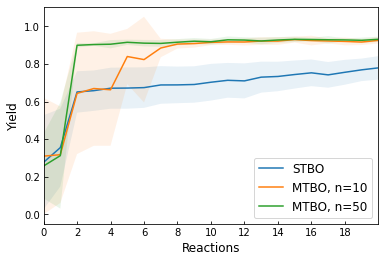

In [31]:
stbo_results = [summit.Runner.load(f"data/kinetics_different/stbo_case1-3_noise_repeat_{i}.json") 
                for i in range(10)]
mtbo_results_lists = [[summit.Runner.load(f"data/kinetics_similar/mtbo_case1-2_noise_{n}-pre-train_repeat_{i}.json") 
                      for i in range(10)]
                      for n in [10,50]]
fig, ax = make_comparison_plot(
    dict(results=stbo_results, label="STBO"),
    dict(results=mtbo_results_lists[0],label="MTBO, n=10"),
    dict(results=mtbo_results_lists[1],label="MTBO, n=50")
)
fig.savefig("figures/stbo_mtbo_kinetics_case1-3_noise_comparison.png", bbox_inches='tight', dpi=300)

## C-N Cross Couplings